In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import silkscreen
from silkscreen.utils import get_reddening
from astropy.coordinates import SkyCoord
import corner
from astropy.visualization import make_lupton_rgb
import paths
from sbi.analysis import check_sbc, run_sbc, sbc_rank_plot
from scipy.stats import binom

device = 'cpu'

if 'snakemake' in globals():
    params = snakemake.params
    print (snakemake.params)
else:
    params = dict(name = 'self_test', seed = 45, Q = 6, st = 0.15)

params_truth = torch.Tensor([6.9908e+00,  7.5028e+00, -7.2542e-01,  5.7358e-04,  4.9089e+00, 3.6964e-01]) #Truth 
gal_dir = f"{paths.data}/self_test/"
obs_dir = gal_dir
post_dir = gal_dir
post_version = 'V27_'

In [6]:

ra,dec = np.loadtxt(obs_dir + 'ra_dec_dw.txt')
try:
    red_vec = get_reddening(SkyCoord(ra,dec, unit = 'deg'), ['DECam_g','DECam_r', 'DECam_z'])
except FileNotFoundError:
    import dustmaps.sfd
    dustmaps.sfd.fetch()
    red_vec = get_reddening(SkyCoord(ra,dec, unit = 'deg'), ['DECam_g','DECam_r', 'DECam_z'])

psfs = np.load(obs_dir+'psfs.npy')
psfs = psfs[:,31-15:31+15,31-15:31+15]

ser_dict = torch.load(obs_dir + 'sersic_param_dict.pt')

obs_arr = torch.load(obs_dir+'cutout.pt')

iso_kwargs = dict(mag_limit=27, mag_limit_band='DECam_r')

obs = silkscreen.SilkScreenObservation(data = obs_arr, imager = 'DECam', filters = ['DECam_g','DECam_r', 'DECam_z'], sky_sb = [ 22.04, 20.91, 18.46],
exp_time = [87*2,67*2,100*2], pixel_scale = 0.262, zpt = 22.5, psf = psfs, distribution= 'sersic', distribution_kwargs=ser_dict, iso_kwargs=iso_kwargs,
extinction_reddening = red_vec)

simmer = silkscreen.simmer.DefaultDwarfFixedAgeSimmer(obs)
prior = silkscreen.priors.get_default_dwarf_fixed_age_prior([5.,10.], [7.,8.], device = device)

/Users/timothymiller/micromamba/envs/pytorch/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/timothymiller/micromamba/envs/pytorch/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(
/Users/timothymiller/Documents/research/packages/silkscreen/silkscreen/priors.py:65: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  return torch.stack([logM_samp

In [14]:
rounds = [0,1,2]

post_list = []

for r in rounds:
    post = torch.load(f'{post_dir}{post_version}posterior_round_{r}.pt', map_location='cpu', )
    post_list.append(post.sample(sample_shape=(50_000,),x = post.default_x).numpy())
prior_samples = prior.sample( (50_000,) ).numpy()

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
#Simulate galaxies from samples of the posterior
inj_img = np.load(f'{obs_dir}for_inj.npy')
post_im_samps = []
for theta_post in post_list[-1][:8]:
    x,y = np.random.randint(1000,2000, size = 2)
    inj_cutout = inj_img[:,x:x+obs_arr.shape[1], y:y+obs_arr.shape[2]]
    gal_img = simmer.get_image_for_injec(x = theta_post)
    fake_obs = gal_img+inj_cutout
    post_im_samps.append(fake_obs)

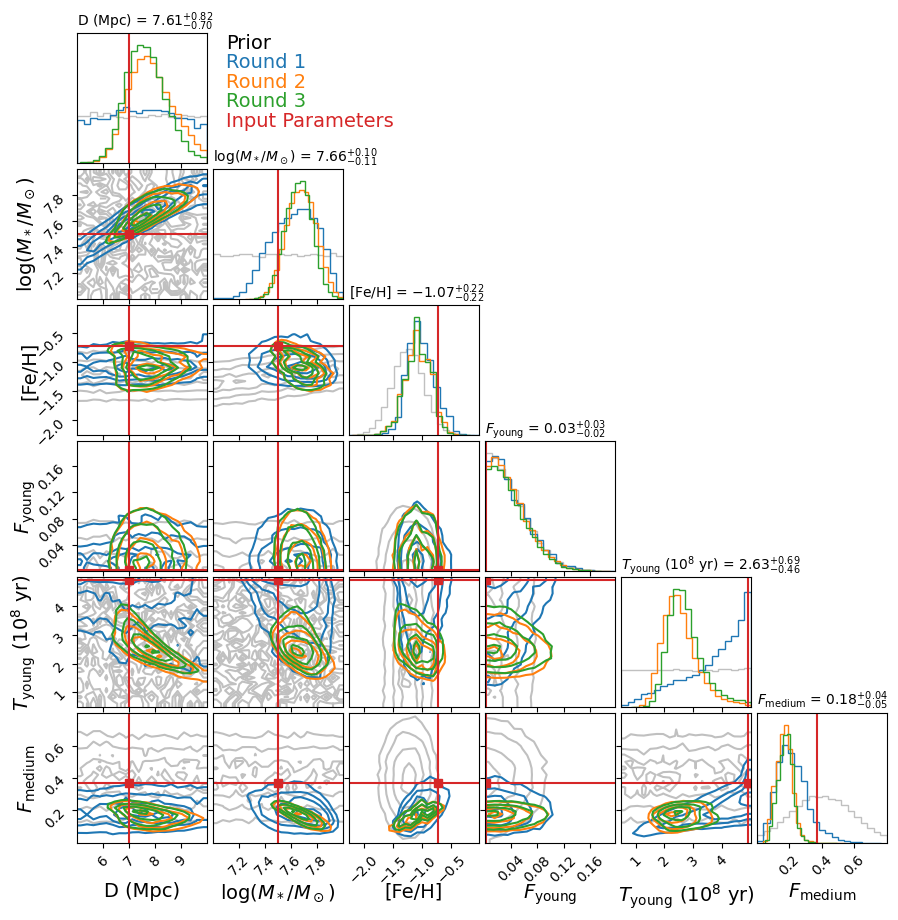

In [53]:
corner_fig = plt.figure(figsize=(9,9))

var_labels = ['D (Mpc)', r'log$(M_* / M_\odot)$', '[Fe/H]', r'$F_{\rm young}$',r'$T_{\rm young}\ (10^8$ yr)',r'$F_{\rm medium}$']
corner.corner(prior_samples, plot_density = False, plot_datapoints = False, color = 'silver', fig = corner_fig,labels= var_labels)

for r in rounds:
    if r == rounds[-1]:
        corner.corner(post_list[r], plot_density = False, plot_datapoints = False, color = f'C{r}', fig = corner_fig,truths=params_truth, truth_color='C3', show_titles= True, labels = var_labels,\
          label_kwargs = {'fontsize':14}, title_kwargs = {'fontsize':10, 'loc':'left'})
    else:
        corner.corner(post_list[r], plot_density = False, plot_datapoints = False, color = f'C{r}', fig = corner_fig)

ax_text = corner_fig.axes[1]
text_fs = 14
ax_text.text(0.1,1,'Prior', color = 'k', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.85,'Round 1', color = 'C0', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.7,'Round 2', color = 'C1', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.55,'Round 3', color = 'C2', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.4,"Input Parameters", color = 'C3', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)

plt.savefig(f"{paths.figures}/self_test_post_corner.pdf")

In [56]:
inj_img = np.load(f'{obs_dir}for_inj.npy')
post_im_samps = []
for theta_post in post_list[-1][:4]:
    x,y = np.random.randint(1000,2000, size = 2)
    inj_cutout = inj_img[:,x:x+obs_arr.shape[1], y:y+obs_arr.shape[2]]
    gal_img = simmer.get_image_for_injec(x = theta_post)
    fake_obs = gal_img+inj_cutout
    post_im_samps.append(fake_obs)

prior_im_samps = []
for theta_post in prior.sample(sample_shape=(4,)):
    x,y = np.random.randint(1000,2000, size = 2)
    inj_cutout = inj_img[:,x:x+obs_arr.shape[1], y:y+obs_arr.shape[2]]
    gal_img = simmer.get_image_for_injec(x = theta_post)
    fake_obs = gal_img+inj_cutout
    prior_im_samps.append(fake_obs)

/var/folders/55/yk32fyfs7kzf9l80rvr6bmg40000gn/T/ipykernel_91112/929583150.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


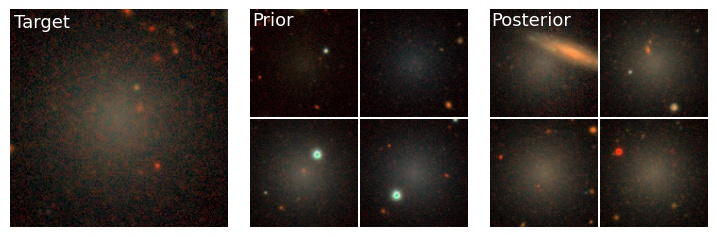

In [91]:
fig = plt.figure(figsize =(9,2.85))


st = params['st']
Q = params['Q']
rgb_obs = make_lupton_rgb(obs_arr[2],obs_arr[1], obs_arr[0], stretch=st, Q = Q, minimum=0e-2)

outer_gs = fig.add_gridspec(1,3, wspace = 0.1)

ax_obs = fig.add_subplot(outer_gs[0])
ax_obs.imshow(rgb_obs)
ax_obs.axis('off')
ax_obs.text( 0.02,0.98, 'Target',ha = 'left', va = 'top', transform = ax_obs.transAxes,color ='w', fontsize = 13)

gs_prior = outer_gs[1].subgridspec(2,2, wspace = 0.02, hspace = 0)
gs_post = outer_gs[2].subgridspec(2,2, wspace = 0.02, hspace = 0)

put_text = False
for gs,im in zip(gs_prior, prior_im_samps):
    ax_cur = fig.add_subplot(gs)
    ax_cur.axis('off')
    rgb_cur = make_lupton_rgb(im[2],im[1], im[0], stretch=st, Q = Q, minimum=0e-2)
    ax_cur.imshow(rgb_cur)
    if not put_text:
        ax_cur.text( 0.02,0.98, 'Prior',ha = 'left', va = 'top', transform = ax_cur.transAxes,color ='w', fontsize = 13)
        put_text = True

put_text = False
for gs, im in zip(gs_post, post_im_samps):
    ax_cur = fig.add_subplot(gs)
    ax_cur.axis('off')
    rgb_cur = make_lupton_rgb(im[2],im[1], im[0], stretch=st, Q = Q, minimum=0e-2)
    ax_cur.imshow(rgb_cur)
    if not put_text:
        ax_cur.text( 0.02,0.98, 'Posterior',ha = 'left', va = 'top', transform = ax_cur.transAxes,color ='w', fontsize = 13)
        put_text = True

fig.tight_layout()
plt.savefig(f'{paths.figures}/self_test_ims.pdf')
plt.show()

In [32]:
t_val,x_val = torch.load(gal_dir+'val_set.pt')
post = torch.load(f'{post_dir}{post_version}posterior_round_0.pt', map_location='cpu', )

num_posterior_samples = 1000
ranks, dap_samples = run_sbc(
    t_val, x_val, post, num_posterior_samples=num_posterior_samples
)# Samples from prior and posterior from intial round of training

check_stats = check_sbc(
    ranks, t_val, dap_samples, num_posterior_samples=num_posterior_samples
)
for k,v in check_stats.items():
    print (k)
    print(v)

ranks_np = ranks.numpy().T

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

ks_pvals
tensor([0.6566, 0.0571, 0.0793, 0.4057, 0.4057, 0.1935])
c2st_ranks
tensor([0.5805, 0.6020, 0.5835, 0.5935, 0.5690, 0.5755])
c2st_dap
tensor([0.5005, 0.5000, 0.5015, 0.4905, 0.5030, 0.4695])


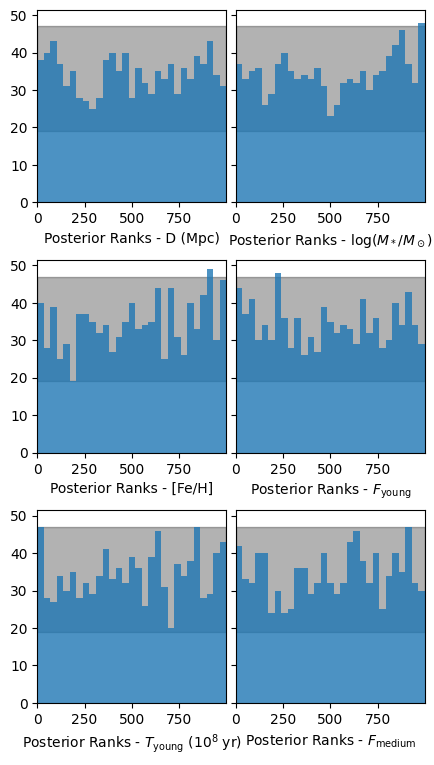

In [109]:
fig, axes = plt.subplots(3,2, figsize = (5,9),sharey= True)
nb = 30
lower = binom(num_posterior_samples, p=1 / (nb + 1)).ppf(0.005) ## Taken from Talts et al. and sbi.analysis module for expected range
upper = binom(num_posterior_samples, p=1 / (nb + 1)).ppf(0.995)
lower,upper
for ranks_cur,name,ax in zip(ranks_np, var_labels, axes.flatten()):
    ax.fill_between([0,1000,], lower, upper, alpha = 0.3, color = 'k')
    ax.hist(ranks_cur, bins = np.linspace(0,999.99, num = nb),alpha = 0.8)
    ax.set_xlim(0,999.99)
    ax.set_xlabel(f'Posterior Ranks - {name}')

fig.subplots_adjust(hspace = 0.3, wspace = 0.05)
plt.savefig(f'{paths.figures}/self_test_sbc.pdf')